# Imports and necessary preparation

In [1]:
import os
current_dir = os.getcwd() if 'current_dir' not in locals() else current_dir
print(f'Current directory: {current_dir}')

%load_ext autoreload
%autoreload 2

%cd {current_dir}/../src/data
from make_dataset import load_dataframe
from dataframe_preprocessing import preprocess, remove_unknowns
from text_preprocessing import simple_row_preprocessing
from analysis.analyze import get_toxic_words

%cd {current_dir}/../src/visualization
from visualize import visualize

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

Current directory: /workspaces/PMLDL_Assignment1/notebooks
/workspaces/PMLDL_Assignment1/src/data


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/workspaces/PMLDL_Assignment1/src/visualization


# Initial data exploration

### Load dataframe from file and preprocess

#### Common preprocessing steps:
1. Simple (meaning preserves) - **used here**:
    1. Lowercasing
    1. Removing punctuation
    1. Removing numbers
    1. Removing double spaces
1. Loosing meaning - **will be considered later**:
    1. Tokenization
    1. Removing of stop words
    1. Stemming and lemmatization

In [3]:
df = load_dataframe()

df_processed = preprocess(df) # add more columns, switch ref and trn
df_processed = df_processed.apply(simple_row_preprocessing, axis=1) # preprocess text in simple way
df_processed = remove_unknowns(df_processed)

##### Initial data

In [4]:
df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


##### Preprocessed

In [5]:
df_processed.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff,ref_length,trn_length,length_difference
0,if alkar floods her with her mental waste it w...,if alkar is flooding her with psychic waste th...,0.79,0.01,0.981983,0.014195,0.968,96,95,1
1,you re becoming disgusting,now you re getting nasty,0.75,0.07,0.999039,0.065473,0.934,27,25,2
2,well we can spare your life,well we could spare your life for one,0.92,0.27,0.985068,0.213313,0.772,29,40,11
3,monkey you have to wake up,ah monkey you ve got to snap out of it,0.66,0.31,0.994215,0.053362,0.941,28,41,13
4,i have orders to kill her,i ve got orders to put her down,0.73,0.18,0.999348,0.009402,0.990,26,32,6


#### Explore the statistics

In [7]:
df_processed[
    ['ref_tox', 'trn_tox', 'tox_diff', 'ref_length', 'trn_length', 'length_difference', 'similarity', 'lenght_diff']
].describe().round(3)

,ref_tox,trn_tox,tox_diff,ref_length,trn_length,length_difference,similarity,lenght_diff
count,577777.000,577777.000,577777.000,577777.000,577777.000,577777.000,577777.000,577777.000
mean,0.940,0.036,0.905,52.539,51.160,8.795,0.758,0.158
std,0.101,0.079,0.126,37.324,37.382,9.030,0.093,0.108
min,0.500,0.000,0.500,2.000,3.000,0.000,0.600,0.000
25%,0.940,0.000,0.870,28.000,26.000,3.000,0.680,0.070
50%,0.984,0.003,0.963,43.000,41.000,6.000,0.750,0.140
75%,0.998,0.027,0.992,66.000,65.000,12.000,0.830,0.240
max,1.000,0.499,1.000,1401.000,969.000,534.000,0.950,0.400


#### Visualization

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

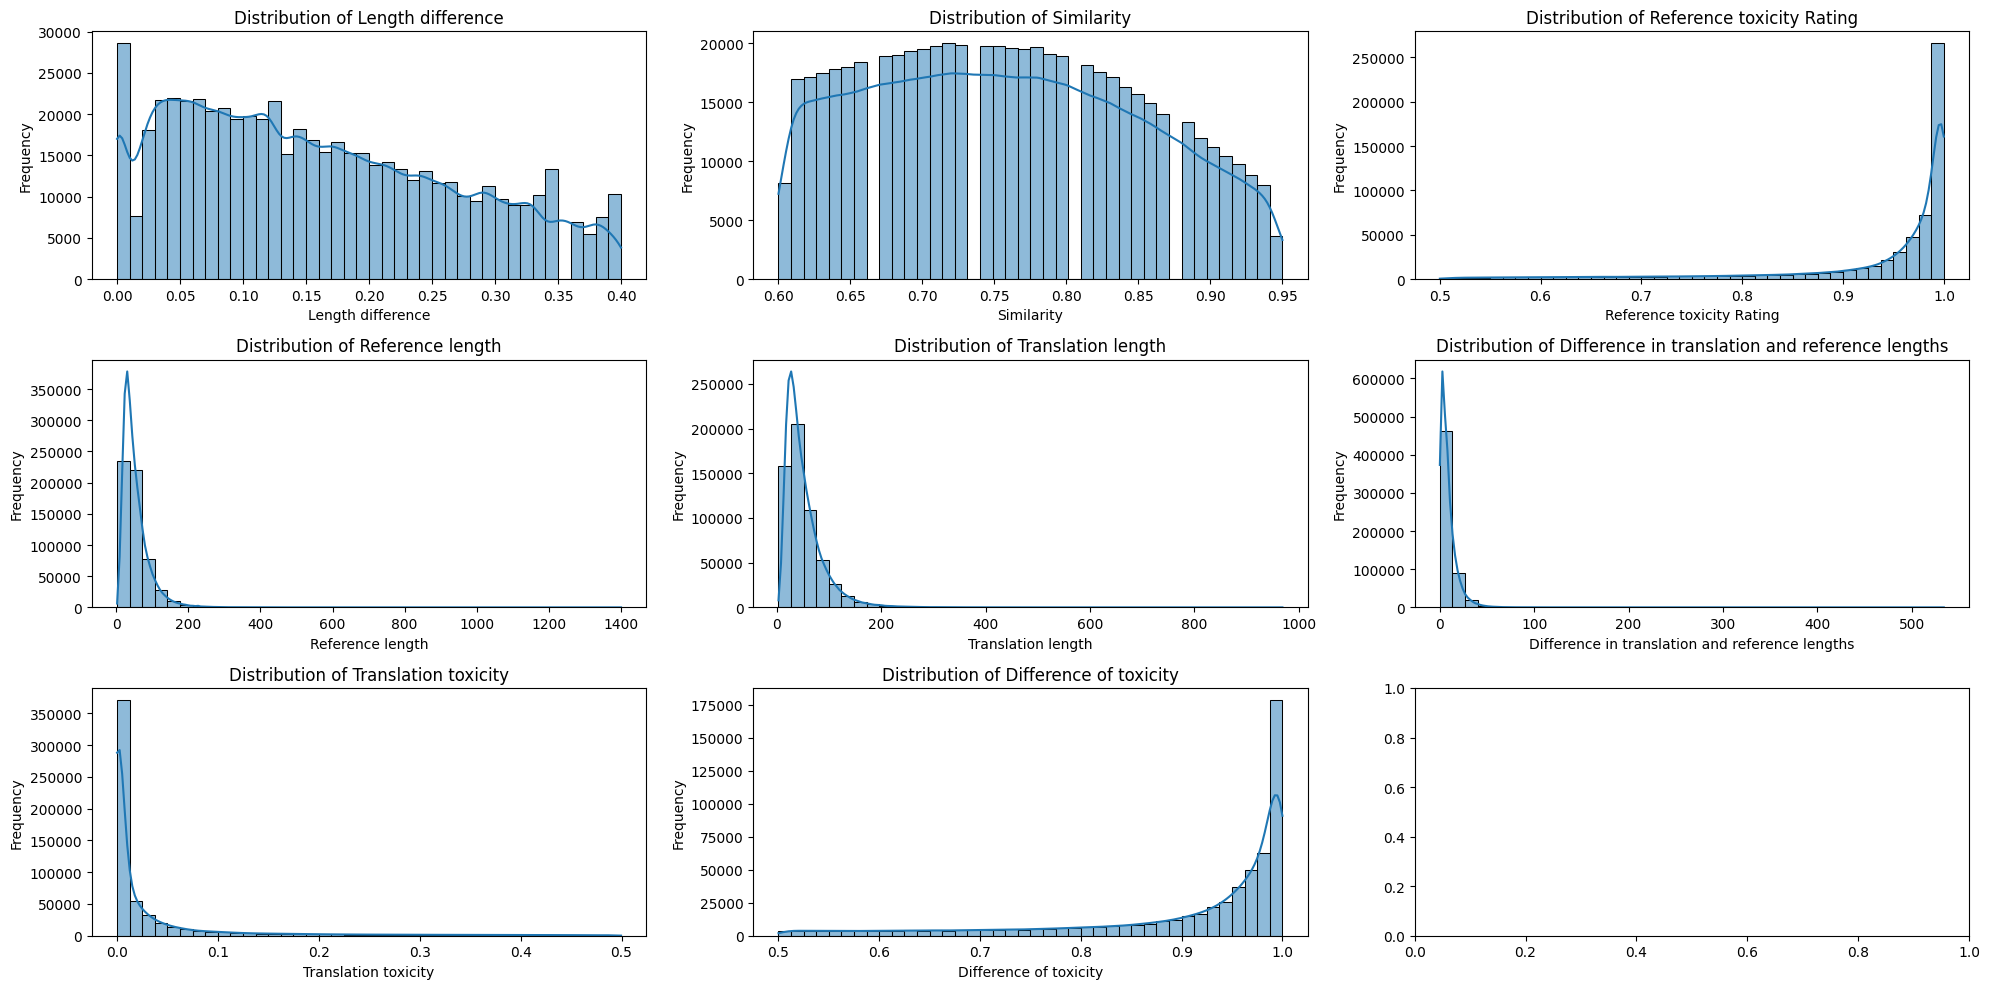

In [34]:
visualize(df_processed)

### Important notes:
1. The distributions of lengths of referenced and translated texts are nearly the same. The 75 percentile of lenght_diff (from the initial) is only 0.25 and of manual length_difference is 12 (characters)
    - Moreover, considering only sentences of length less than 100 will cover more than 75% of the dataset
1. The difference of toxicity levels of referenced and translated texts are severely skewed to the right (towards 1)
    - It is also good, since taking only a subset of 75% most toxic reference provides a good diverse (in terms of toxicity) pair of sentences which will be good for training the model.

#### Words statistics. Separate words used in toxic and translation sentences
toxic - those that do not appear in translated text but were in toxic reference

In [22]:
toxic_words, translated_words = get_toxic_words(df_processed, log=True)

Number of words in toxic dataset: 73158
Number of words in translated dataset: 79540
Number of toxic words that are not in translation: 19659


As you can see from here, the dataset of bad sentences has 7% less words than the good text contains. It may also be the evidence of the scarcity of vocabulary words when you express yourself in a bad manner.

##### Bad words. 
Disclaimer: The content of the cell below is 18+

In [32]:
top_bad_words, bottom_bad_words = list(toxic_words.most_common(18)), list(toxic_words.most_common())[-18:]
for t, b in zip(top_bad_words, bottom_bad_words):
    print(t,b)

('motherfucker', 621) ('obsolescent', 1)
('faggot', 554) ('thaks', 1)
('dicks', 355) ('thom', 1)
('scumbag', 214) ('sepulchral', 1)
('motherfuckers', 200) ('matosevic', 1)
('motherfucking', 197) ('unhomed', 1)
('fuckers', 182) ('wss', 1)
('stupidest', 168) ('scotia', 1)
('damnedest', 75) ('thiev', 1)
('damnit', 74) ('ringside', 1)
('wankers', 68) ('hooches', 1)
('arsehole', 67) ('pinstriped', 1)
('pigheaded', 65) ('sexualitywill', 1)
('faggots', 63) ('witched', 1)
('sissies', 53) ('appetitefor', 1)
('shitheads', 37) ('cohesiveness', 1)
('shins', 36) ('memorised', 1)
('electrocute', 31) ('interstitial', 1)


As you can see. There aren't some bad words here. 

For example, the word 'fuck' is preserved in translation. Let's see where it appears in the translated dataset

In [64]:
common_bad_words_in_english = ['fuck', 'hell', 'asshole', 'bitch', 'bastard', 'damn', 'piss', 'damn']
for word in common_bad_words_in_english:
    print(f'{word} in translated text appears: {translated_words[f"{word}"]} times')


fuck in translated text appears: 114 times
hell in translated text appears: 14495 times
asshole in translated text appears: 14 times
bitch in translated text appears: 24 times
bastard in translated text appears: 69 times
damn in translated text appears: 1076 times
piss in translated text appears: 710 times
damn in translated text appears: 1076 times


In [56]:
# sort first by toxicity of "good" sentences ('translation)
df_sorted = df_processed.sort_values(by=['trn_tox'], ascending=[True])[['translation', 'trn_tox', 'reference', 'ref_tox']].round(3).values

bad_rows = []
for row in df_sorted:
    if ('fuck' in row[0]):
        bad_rows.append(row)
        
print('Translated sentence, its score, reference sentence and its score:')        
print(*bad_rows[10:20], sep='\n')

Translated sentence, its score, reference sentence and its score:
['fuckyou roger' 0.001 'fuck you roger' 1.0]
['fuckyou man' 0.001 'shit man' 1.0]
['now i paid you a lot offucking money to help put this together' 0.001
 'now i paid you a bunch of fucking money to take care of' 0.988]
['fuckyou finch' 0.001 'fuck you finch' 1.0]
['it don t fuck up the baby immunities' 0.001
 'she doesn t fuck with her immunity' 0.993]
['you got it there s going to be a lot offucking trouble ifthis car gets wet'
 0.001 'there s gonna be a lot of fucking trouble if this car is wet'
 0.982]
['and i am not planning to let anything fuck that up' 0.001
 'and i m not planning to let anything get fucked up' 0.988]
['not fuck things up' 0.001 'just don t fuck up' 0.991]
['i d never fuck that up' 0.002 'i ll never fuck up' 0.956]
['fuckyour mersin' 0.002 'fucking mersin' 1.0]


Apparently, the sentence different in one space is considered 99% less toxic.

Examples: 
- **'fuckyou finch'** with toxicity 0.001 and **'fuck you finch'** with almost 1
- **'fuckyou raheem'** - 0.001 & **'fuck you raheem'** - 1.0. From initial dataset: 'Fuckyou, Raheem!' - 0.0006 & 'fuck you, Raheem!' - 1
- **'fuckyou man'** - 0.001 & **'shit man'** - 1.0

#### Conclusion:

Some words, such as 'fuck' are not considered as 100% toxic. There are many sentences that are containing such words and assessed with very low toxicity rating (below 0.001).

It means that some single bad words are not actually bad. The phrase is what is much more important. 

Example: 
- fuck up / get fucked up (99% toxic) -> fuck things/that up (less than 1%)


While some words, such as the most popular "motherfucker" has to be avoided by all price

All this will be took into account by the model while training.


### 

# Evalution
## Methods
1. BLUE score
1. Perplexity
1. BERT assesment
1. Other nlp assesment


# Test

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2"  # You can use other model names like "gpt2-medium" or "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-30 12:37:02.770132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-30 12:37:02.770185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-30 12:37:02.775373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 12:37:03.817451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow

In [179]:
train_texts = [
    {"toxic": "You're such an idiot!", "rephrased": "I disagree with you."},
    {"toxic": "This is terrible!", "rephrased": "This is not ideal."},
    # Add more pairs as needed
]

tokenizer.pad_token = tokenizer.eos_token
def tok(sent):
    return tokenizer(sent, padding='max_length', truncation=True, max_length=10, return_tensors="pt")

tok(train_texts[0]['toxic']), tok(train_texts[0]['rephrased'])

({'input_ids': tensor([[ 1639,   821,   884,   281, 22324, 21551,     0, 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])},
 {'input_ids': tensor([[   40, 12546,   351,   345,    13, 50256, 50256, 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])})

In [11]:
prompt = "What is the synonim to the word fuck? Tell only one word as our output"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50)

# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True, tempreture=0)

print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the synonim to the word fuck? Tell only one word as our output.

The synonym for fuck is a word that is used to describe a sexual act. It is often used in the context of a relationship, but


# Methods
1. Select toxic words or parts and then paraphrase them
1. Translate into French as the most similar to English and then back to English


identify toxic words and replace them with non-toxic synonyms.
since Such markers (i) carry most of stylistic information of a sentence(i.e.their presence is a strong indicator of this class),(ii) have synonyms which are free from this stylistic information.
need to somehow identify what words are toxic in the current dataset

# Test T5 as a translation from toxic to neutral

In [24]:
from datasets import load_metric, Dataset
model_checkpoint = "t5-small"
metric = load_metric("sacrebleu")

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq,  Seq2SeqTrainer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

2023-10-01 09:33:08.631043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-01 09:33:08.631096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-01 09:33:08.634980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-01 09:33:09.595260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
max_input_length = 128
max_target_length = 128
source_type = 'reference'
target_type = 'translation'

prefix = "paraphrase from toxic to neutral:"

dataset_dict = {
    "reference": df["reference"].tolist(),
    "translation": df["translation"].tolist()
}
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['reference', 'translation'],
    num_rows: 577777
})

In [27]:
def preprocess_function(examples):
    print(examples)
    inputs = [prefix + ex for ex in examples[source_type]]
    targets = list(examples[target_type])
    
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    labels = tokenizezr(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# defining the parameters for training
batch_size = 32
model_name = model_checkpoint.split("/")[-1]
print(model_name)
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    report_to='tensorboard',
)